<a href="https://colab.research.google.com/github/sultankeles/Breast_Cancer_Diagnosis/blob/main/Breast_Cancer_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Breast Cancer Diagnosis**

The aim of this project is to create an image classification system which can detect breast cancer by stage and location.

# **1. Dataset Preparation**

## 1.1. Download and Extract INbreast Dataset

> The INbreast dataset was downloaded from Google Drive link and extracted automatically if not already available.

    file_id    : The identification number of the dataset in Drive.
    zip_output : Specifies the name under which the downloaded .zip file will be saved on the local disk.
    extract_to : Defines the folder where the extracted .zip file will be saved.

In [ ]:
!pip install -q gdown

In [ ]:
import zipfile
import gdown
import os

file_id = "1746ML0cBtTYZb-O-kQ39gd9GfhvW0kt4"
zip_output = "INbreast_Release.zip"
extract_to = "/content/INbreast_Extracted"

if not os.path.exists(zip_output):
    gdown.download(f"https://drive.google.com/uc?id={file_id}", zip_output, quiet=False)
else:
    print("ZIP file already exists!")


if not os.path.exists(extract_to):
    print("Extracting ...")
    with zipfile.ZipFile(zip_output, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print("Extraction completed.")
else:
    print("Dataset already extracted!")

Downloading...
From (original): https://drive.google.com/uc?id=1746ML0cBtTYZb-O-kQ39gd9GfhvW0kt4
From (redirected): https://drive.google.com/uc?id=1746ML0cBtTYZb-O-kQ39gd9GfhvW0kt4&confirm=t&uuid=fea2fea5-42a0-48ad-a342-5f0f1b430da4
To: /content/INbreast_Release.zip
100%|██████████| 2.01G/2.01G [00:41<00:00, 47.9MB/s]


Extracting ...
Extraction completed.


## 1.2 Convert DICOM to JPG

DICOM (Digital Imaging and Communications in Medicine) is a standard file format produced by medical imaging devices.

> DICOM files were read with `pydicom`

> Coverted to `JPG` format, normalized using `numpy` and saved using `cv2.imwrite()`in a designated folder (`jpg_output_dir`) using OpenCV.

> A progress bar was shown via `tqdm`.

In [ ]:
dicom_dir = "/content/INbreast_Extracted/INbreast Release 1.0/AllDICOMs"
jpg_output_dir = "/content/JPGs"

In [ ]:
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 21.7 MB/s eta 0:00:00


In [ ]:
import pydicom
import cv2
import numpy as np
from tqdm import tqdm

dicom_dir = "/content/INbreast_Extracted/INbreast Release 1.0/AllDICOMs"
jpg_output_dir = "/content/JPGs"
os.makedirs(jpg_output_dir, exist_ok = True)

def convert_dicom_to_jpg(dicom_path, jpg_path):
    dcm = pydicom.dcmread(dicom_path)
    img = dcm.pixel_array.astype(float)

    # Normalize to 0–255
    img = (np.maximum(img, 0) / img.max()) * 255.0
    img = np.uint8(img)

    # Save
    cv2.imwrite(jpg_path, img)

for filename in tqdm(os.listdir(dicom_dir)):
    if filename.endswith(".dcm"):
        file_id = filename.split("_")[0]
        dicom_path = os.path.join(dicom_dir, filename)
        jpg_path = os.path.join(jpg_output_dir, f"{file_id}.jpg")
        convert_dicom_to_jpg(dicom_path, jpg_path)

100%|██████████| 412/412 [00:50<00:00,  8.20it/s]


### 1.2.1. Display Sample Converted JPG Images

>   The specified folder (`jpg_dir`) was scanned and filenames ending with .jpg were collected.

>    Each image was read using `cv2.imread()` and converted from BGR to RGB color format for accurate visualization with matplotlib.

>   Images were resized to a standard size using `cv2.resize()` to maintain uniform layout.

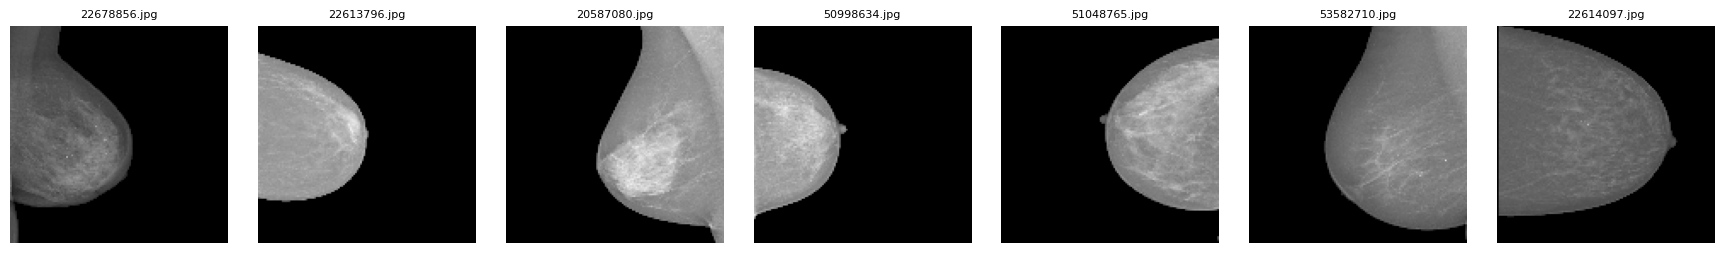

In [ ]:
import os
import cv2
import random
import matplotlib.pyplot as plt

IMG_SIZE = 128

def show_sample_jpgs(jpg_dir, samples = 6):
    images = [f for f in os.listdir(jpg_dir) if f.lower().endswith('.jpg')]
    random.shuffle(images)
    selected = images[:samples]

    plt.figure(figsize = (samples * 2.5, 2.5))
    for i, img_name in enumerate(selected):
        img_path = os.path.join(jpg_dir, img_name)
        img = cv2.imread(img_path)

        if img is None:
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

        plt.subplot(1, samples, i + 1)
        plt.imshow(img)
        plt.title(img_name[:15], fontsize = 8)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_sample_jpgs("/content/JPGs", samples = 7)

## 1.3 Convert ROI XML to JSON

ROI (Region of Interest) annotations which are identify the cancer region associated with each image, converted `JSON` format to make useable by Machine Learning models.

> ROI coordinates were extracted from XML files using `ElementTree`(`ET`) library.

> Converted to (`x, y`) format.

> Saved as structured JSON annotations for each image to `output_json_path`.



In [ ]:
import xml.etree.ElementTree as ET
import json
import re

xml_dir = "/content/INbreast_Extracted/INbreast Release 1.0/AllXML"
output_json_path = "/content/annotations.json"
annotations = {}

def parse_point(point_str):
    # Remove parentheses and split into float x, y
    x, y = re.findall(r"[\d.]+", point_str)
    return {"x": int(float(x)), "y": int(float(y))}

for file in os.listdir(xml_dir):
    if not file.endswith(".xml"):
        continue

    xml_path = os.path.join(xml_dir, file)
    tree = ET.parse(xml_path)
    root = tree.getroot()

    image_id = file.replace(".xml", "") + ".jpg"
    rois = []

    # Navigate to ROIs
    for roi_group in root.iter("array"):
        for roi in roi_group.findall("dict"):
            name = None
            points = []
            keys = list(roi)
            for i in range(len(keys)):
                if keys[i].tag == "key" and keys[i].text == "Name":
                    name = keys[i+1].text
                if keys[i].tag == "key" and keys[i].text == "Point_px":
                    px_array = keys[i+1].findall("string")
                    for p in px_array:
                        points.append(parse_point(p.text))
            if name and points:
                rois.append({
                    "label": name,
                    "points": points
                })

    if rois:
        annotations[image_id] = rois

# Save to JSON
with open(output_json_path, "w") as f:
    json.dump(annotations, f, indent=4)

print(f"ROI annotations parsed: {len(annotations)} images.")

ROI annotations parsed: 343 images.


# **2. Preprocessing**

In this section, basic preprocessing steps were performed on the INbreast dataset.

First, the folder structure of the INbreast dataset was scanned using `os.walk()` to verify its organization and prepare for further processing.

In [ ]:
base_path = "/content/INbreast_Extracted/INbreast Release 1.0"

for root, dirs, files in os.walk(base_path):
    print(f"\n {root}")

    if dirs:
        print(f"   >Subdirectories: {dirs}")

    if files:
        for f in files[:5]:
            print(f"    - {f}")


 /content/INbreast_Extracted/INbreast Release 1.0
   >Subdirectories: ['AllROI', 'MedicalReports', 'AllXML', 'PectoralMuscle', 'AllDICOMs']
    - INbreast.xls
    - README.txt
    - inbreast.pdf
    - INbreast.csv

 /content/INbreast_Extracted/INbreast Release 1.0/AllROI
    - 30011647.roi
    - 50997678.roi
    - 22580098.roi
    - 22579754.roi
    - 24055328.roi

 /content/INbreast_Extracted/INbreast Release 1.0/MedicalReports
    - 11e6732579acf692.txt
    - c4b995eddb3c510c.txt
    - e634830794f5c1bd.txt
    - 2f1104b3cda7f145.txt
    - 5291e1aee2bbf5df.txt

 /content/INbreast_Extracted/INbreast Release 1.0/AllXML
    - 22579847.xml
    - 50996110.xml
    - 53582656.xml
    - 22670511.xml
    - 22580038.xml

 /content/INbreast_Extracted/INbreast Release 1.0/PectoralMuscle
   >Subdirectories: ['Pectoral Muscle ROI', 'Pectoral Muscle XML']

 /content/INbreast_Extracted/INbreast Release 1.0/PectoralMuscle/Pectoral Muscle ROI
    - 50997597_muscle.roi
    - 50998059_muscle.roi
    - 2

## 2.1. Data Reading and Review

The INbreast dataset in `.csv` format was read using `pandas` with the appropriate semicolon delimiter.

> A new column was created by appending `.jpg` to image names.

> Relevant columns were selected such as `laterality`, `view`, `breast density (ACR)`, and `BI-RADS levels` and displayed using `df_clean.head()`.

In [ ]:
import pandas as pd

csv_path = "/content/INbreast_Extracted/INbreast Release 1.0/INbreast.csv"
df = pd.read_csv(csv_path, sep = ";")
df["filename"] = df["File Name"].astype(str) + ".jpg"

df_clean = df[["filename", "Laterality", "View", "ACR", "Bi-Rads"]].copy()
df_clean.columns = ["filename", "laterality", "view", "acr_density", "birads_label"]

df_clean.head()

,filename,laterality,view,acr_density,birads_label
0,22678622.jpg,R,CC,4,1
1,22678646.jpg,L,CC,4,3
2,22678670.jpg,R,MLO,4,1
3,22678694.jpg,L,MLO,4,3
4,22614074.jpg,R,CC,2,5


## 2.2. BI-RADS Class Distribution

The distribution of `BI-RADS` (Breast Imaging Reporting and Data System) labels in the dataset was analyzed o identify potential class imbalance.

A clear class imbalance was observed in the dataset. While `BI-RADS 2` had the most samples, classes such as `4b` and `6` had far fewer.

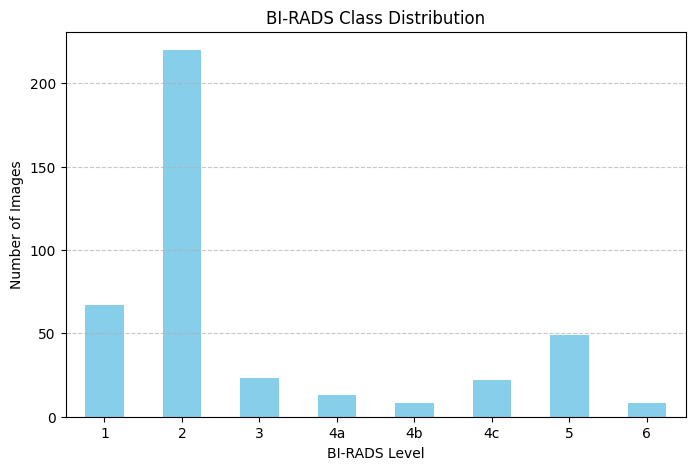

In [ ]:
import matplotlib.pyplot as plt

# Count class distribution
birads_counts = df_clean["birads_label"].value_counts().sort_index()

# Visualize
plt.figure(figsize = (8, 5))
birads_counts.plot(kind = "bar", color = "skyblue")
plt.title("BI-RADS Class Distribution")
plt.xlabel("BI-RADS Level")
plt.ylabel("Number of Images")
plt.xticks(rotation = 0)
plt.grid(axis = "y", linestyle = "--", alpha = 0.7)
plt.show()

### 2.2.1. Sorting Images into Folders Based on BI-RADS Levels

- Images were organized into separate folders based on their BI-RADS labels for class-based training.

- Medical label descriptions were mapped using `label_map` dictionary.

- A bar chart was created to visualize image counts and class meanings.

In [ ]:
import shutil
from tqdm import tqdm

img_source_dir = "/content/JPGs"
output_dir = "/content/BI-RADS_split"
os.makedirs(output_dir, exist_ok=True)

for _, row in tqdm(df_clean.iterrows(), total=len(df_clean), desc = "Organizing images"):
    label = str(row["birads_label"]).strip()
    src = os.path.join(img_source_dir, row["filename"])
    dst_dir = os.path.join(output_dir, f"BIRADS_{label}")
    os.makedirs(dst_dir, exist_ok=True)
    dst = os.path.join(dst_dir, row["filename"])

    if os.path.exists(src):
        shutil.copy(src, dst)

Organizing images: 100%|██████████| 410/410 [00:00<00:00, 1100.07it/s]


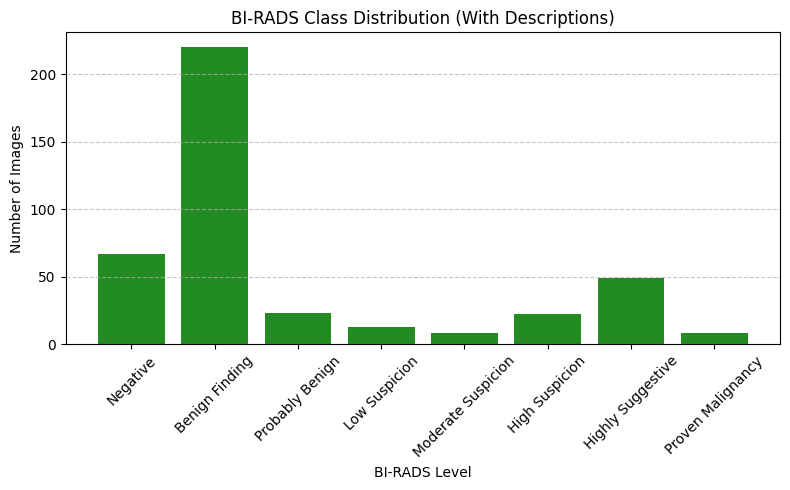

In [ ]:
import matplotlib.pyplot as plt

# Label descriptions
label_map = {
    "1": "Negative",
    "2": "Benign Finding",
    "3": "Probably Benign",
    "4a": "Low Suspicion",
    "4b": "Moderate Suspicion",
    "4c": "High Suspicion",
    "5": "Highly Suggestive",
    "6": "Proven Malignancy"
}

def extract_label(folder_name):
    return folder_name.split("_")[-1].lower()

class_counts = {
    class_name: len([f for f in os.listdir(os.path.join(output_dir, class_name)) if f.endswith(".jpg")])
    for class_name in sorted(os.listdir(output_dir)) if class_name.startswith("BIRADS_")
}

sorted_labels = sorted(class_counts.keys(), key=lambda x: extract_label(x))

# Plot the chart
plt.figure(figsize=(8, 5))
plt.bar(
    [label_map.get(extract_label(l), extract_label(l)) for l in sorted_labels],
    [class_counts[l] for l in sorted_labels],
    color = "forestgreen"
)
plt.title("BI-RADS Class Distribution (With Descriptions)")
plt.xlabel("BI-RADS Level")
plt.ylabel("Number of Images")
plt.xticks(rotation = 45)
plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)
plt.tight_layout()
plt.show()

# **3. Augmentation**

Data augmentation process was applied to BI-RADS classes to prevent biased learning caused by unequal class distributions during model training using `ImageDataGenerator`.

> Images were roteted between -2 and +2 degrees, applied 10% zoom-in and zoom-out, shifted horizontally and vertically by up to 10% and flipped horizontally, while filled empty areas with the nearest pixel values via `fill_mode='nearest'`.

> Only classes with fewer than target number (225) were augmented and images were saved with the prefix "aug". Finally, a bar chart was generated to visualize the updated distribution.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

datagen = ImageDataGenerator(
    rotation_range = 2,
    zoom_range = 0.1,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

target_count = 225
base_dir = output_dir  # /content/BI-RADS_split

for class_name in sorted(os.listdir(base_dir)):
    if class_name == "BIRADS_2":
        continue

    class_path = os.path.join(base_dir, class_name)
    images = [f for f in os.listdir(class_path) if f.endswith(".jpg")]
    to_generate = target_count - len(images)

    if to_generate <= 0:
        continue

    generated = 0
    while generated < to_generate:
        for img_name in images:
            img_path = os.path.join(class_path, img_name)
            img = load_img(img_path, target_size = (224, 224))
            x = img_to_array(img)
            x = x.reshape((1,) + x.shape)

            for _ in datagen.flow(x, batch_size = 1,
                                  save_to_dir = class_path,
                                  save_prefix = "aug", save_format = "jpg"):
                generated += 1
                if generated >= to_generate:
                    break
            if generated >= to_generate:
                break

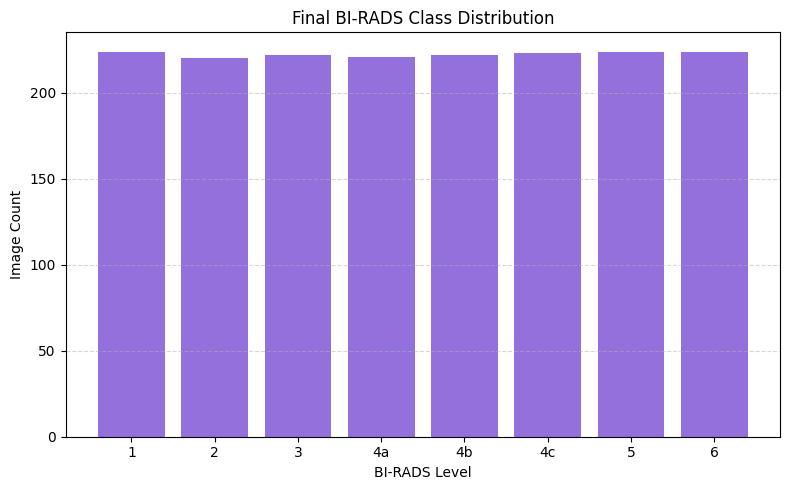

In [ ]:
birads_counts_aug = {
    name: len([f for f in os.listdir(os.path.join(base_dir, name)) if f.endswith(".jpg")])
    for name in sorted(os.listdir(base_dir)) if name.startswith("BIRADS_")
}

x_labels = [extract_label(k) for k in birads_counts_aug.keys()]
y_counts = list(birads_counts_aug.values())

plt.figure(figsize=(8, 5))
plt.bar(x_labels, y_counts, color="mediumpurple")
plt.title("Final BI-RADS Class Distribution")
plt.xlabel("BI-RADS Level")
plt.ylabel("Image Count")
plt.grid(axis = "y", linestyle = "--", alpha = 0.5)
plt.tight_layout()
plt.show()

## 3.1. Show Sample Augmented Images

This step was used to visually inspect whether any significant distortion occurred in the images during the data augmentation process.

> Augmented images converted to RGB format, rescaled to (`128x128`) to visualise.

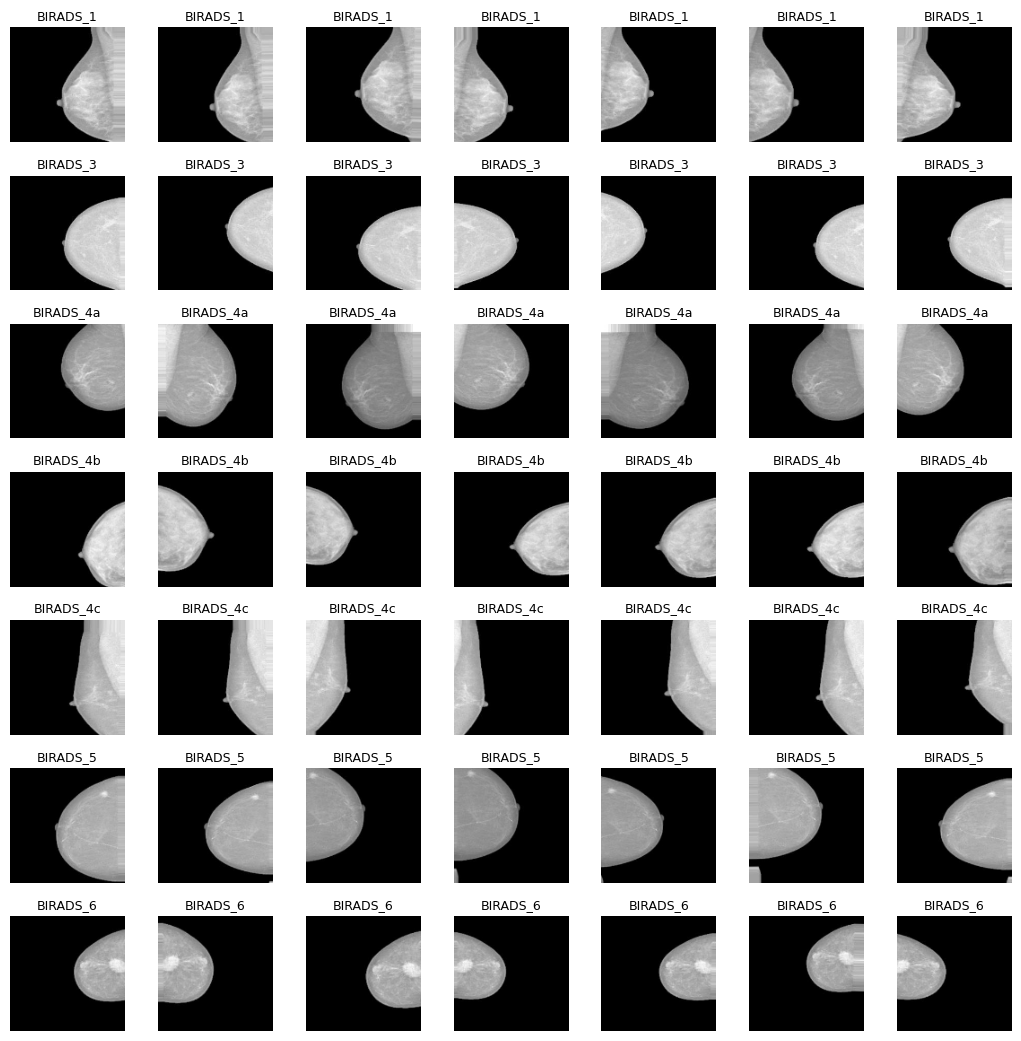

In [ ]:
import os
import cv2
import random
import matplotlib.pyplot as plt

IMG_SIZE = 128

def show_augmented_images_from_folders(base_dir, class_filter = None, samples = 7):
    class_folders = [f for f in os.listdir(base_dir)
                     if os.path.isdir(os.path.join(base_dir, f)) and f.startswith("BIRADS_")]

    if class_filter:
        class_folders = [f for f in class_folders if f in class_filter]

    rows = len(class_folders)
    cols = samples
    plt.figure(figsize = (cols * 1.5, rows * 1.5))
    i = 1

    for class_name in sorted(class_folders):
        class_path = os.path.join(base_dir, class_name)
        images = [f for f in os.listdir(class_path) if f.startswith("aug") and f.endswith(".jpg")]
        random.shuffle(images)

        for img_name in images[:samples]:
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)

            if img is None:
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

            plt.subplot(rows, cols, i)
            plt.imshow(img)
            plt.title(class_name, fontsize = 9)
            plt.axis('off')
            i += 1

    plt.tight_layout()
    plt.show()

show_augmented_images_from_folders(base_dir="/content/BI-RADS_split")

# **4. Dataset Splitting**

In this section, a basic data loading and labeling step was performed to prepare the data for model training.

> Images from BI-RADS folders were loaded, resized to `224×224`, normalized, and stored as `NumPy` arrays.

> Class labels were converted to numeric format using a `label_map` dictionary.

In [ ]:
import os
import cv2
import numpy as np

original_dir = "/content/BI-RADS_split"

all_classes = sorted(os.listdir(original_dir))

label_map = {}
for idx, label in enumerate(all_classes):
    label_map[label] = idx

img_size = 224

X = []
y = []

for label in all_classes:
    class_path = os.path.join(original_dir, label)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)

        if img is not None:
            img = cv2.resize(img, (img_size, img_size))
            img = img / 255.0
            X.append(img)
            y.append(label_map[label])


X = np.array(X, dtype=np.float32)
y = np.array(y)
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1780, 224, 224, 3)
y shape: (1780,)


## 4.1. Train-Test-Split

> The dataset was split into training (80%) and test (20%) sets using `train_test_split`.

> Stratification was applied to preserve class distribution across sets.

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (1424, 224, 224, 3)
y_train shape: (1424,)


# **5. Custom CNN Model**

> Custom Convolutional Neural Network (CNN) was implemented to classify mammogram images into BI-RADS categories.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

## 5.1. Model Architecture

> Target labels were one-hot encoded using `to_categorical()` for multi-class classification.

> The architecture includes two convolutional layers with `ReLU` activation, followed by `MaxPooling`.

> Features are flattened and passed through a fully connected layer with dropout regularization.

> The last dense layer uses `softmax` to output class probabilities.

> Model was compiled with `categorical_crossentropy` loss and optimized with Adam; accuracy was tracked as the primary metric.

In [ ]:
img_size = 224
num_classes = 8

if y_train.ndim != 2:
    y_train = to_categorical(y_train, num_classes = num_classes)
if y_test.ndim != 2:
    y_test = to_categorical(y_test, num_classes = num_classes)

model_cnn = Sequential([
    Conv2D(32, (3, 3), activation = 'relu', input_shape = (img_size, img_size, 3)),
    MaxPooling2D(pool_size = (2, 2)),

    Conv2D(64, (3, 3), activation = 'relu'),
    MaxPooling2D(pool_size = (2, 2)),

    Flatten(),
    Dense(128, activation = 'relu'),
    Dropout(0.5),
    Dense(num_classes, activation = 'softmax')
])

# Compile
model_cnn.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
    )

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## 5.2. Training

> The model was trained for up to 50 epochs with a `batch_size` of 32.

> `EarlyStopping` monitored validation accuracy to prevent overfitting.

> `ModelCheckpoint` saved the best-performing model as `"best_model_cnn.keras"`.

> Total training time was recorded for final comparison.

In [ ]:
# EarlyStopping
early_stop = EarlyStopping(
    monitor = 'val_accuracy',
    patience = 5,
    restore_best_weights = True
)

In [ ]:
# ModelCheckpoint
checkpoint = ModelCheckpoint(
    "best_model_cnn.keras",
    monitor = 'val_accuracy',
    save_best_only = True,
    verbose = 1
)

In [ ]:
import time
start = time.time()

history_cnn = model_cnn.fit(
    X_train, y_train,
    validation_data = (X_test, y_test),
    epochs = 50,
    batch_size = 32,
    callbacks = [early_stop, checkpoint],
    verbose = 1
)

end = time.time()
total_seconds = end - start
minutes = total_seconds // 60
seconds = total_seconds % 60

print(f"Training time: {int(minutes)} minutes {int(seconds)} seconds")

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.2801 - loss: 2.4549
Epoch 1: val_accuracy improved from -inf to 0.54494, saving model to best_model_cnn.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 170ms/step - accuracy: 0.2816 - loss: 2.4438 - val_accuracy: 0.5449 - val_loss: 1.3271
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5996 - loss: 1.1421
Epoch 2: val_accuracy improved from 0.54494 to 0.55899, saving model to best_model_cnn.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.6000 - loss: 1.1416 - val_accuracy: 0.5590 - val_loss: 1.2561
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6816 - loss: 0.9295
Epoch 3: val_accuracy improved from 0.55899 to 0.64045, saving model to best_model_cnn.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.6821 - loss: 0.9278 - val_accuracy: 0.6404 - val_loss: 1.1215
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7537 - loss: 0.6898
Epoch 4: val_accuracy improved fro

## 5.3. Evaluation

> The best saved model was reloaded and evaluated on the test set to report final accuracy and loss, measuring generalization.

In [ ]:
from tensorflow.keras.models import load_model

model_cnn.load_weights("best_model_cnn.keras")
loss, acc = model_cnn.evaluate(X_test, y_test, verbose = 1)
print(f"\n Test Accuracy: {acc:.4f} — Test Loss: {loss:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7329 - loss: 1.7661

 Test Accuracy: 0.7247 — Test Loss: 1.8584


## 5.4. Prediction

The trained model was prepared to evaluate classification performance by making predictions on the test data. The `model.predict()` function was used to obtain class probabilities for each image.

> The class label with the highest probability was selected using `np.argmax()`, producing the predicted results.

> The true labels (`y_test`) were also converted to class indices in the same way for comparison.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [ ]:
best_model = load_model("best_model_cnn.keras")

# Prediction
y_pred_probs = best_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis = 1)

# Ground truth
if y_test.ndim > 1 and y_test.shape[1] > 1:
    y_true = np.argmax(y_test, axis = 1)
else:
    y_true = y_test

class_names = ["1", "2", "3", "4a", "4b", "4c", "5", "6"]

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


## 5.5. Classification Report

> `classification_report()` function provides metrics such as `precision`, `recall`, `F1-score`, and `support` for each class.

The `target_names` parameter was used to display class names instead of numeric labels.

In [ ]:
print("Custom CNN Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

Custom CNN Classification Report:

              precision    recall  f1-score   support

           1       0.73      0.73      0.73        45
           2       0.50      0.55      0.52        44
           3       0.67      0.59      0.63        44
          4a       0.78      0.70      0.74        44
          4b       0.73      0.91      0.81        44
          4c       0.86      0.84      0.85        45
           5       0.64      0.56      0.60        45
           6       0.89      0.91      0.90        45

    accuracy                           0.72       356
   macro avg       0.72      0.72      0.72       356
weighted avg       0.73      0.72      0.72       356



## 5.6. Confusion Matrix

> Confusion Matrix was generated to analyze misclassifications between BI-RADS categories, highlighting the confusion between classes.

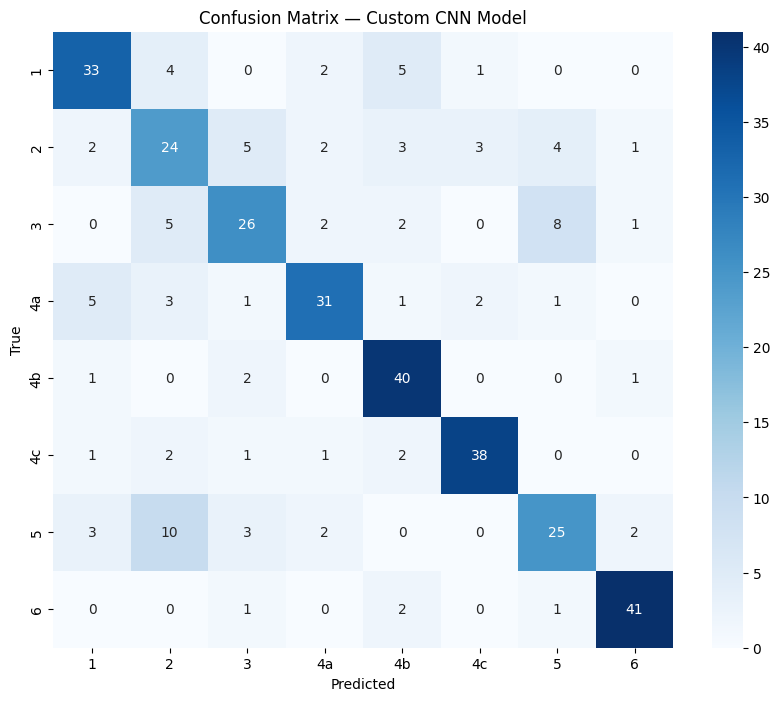

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize = (10, 8))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = class_names, yticklabels = class_names)
plt.title("Confusion Matrix — Custom CNN Model")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## 5.7. Accuracy & Loss Graphs

> The model's learning behavior over time, including overfitting or underfitting tendencies, was analyzed.

> Metrics for both training and validation were retrieved from the `history.history` object.

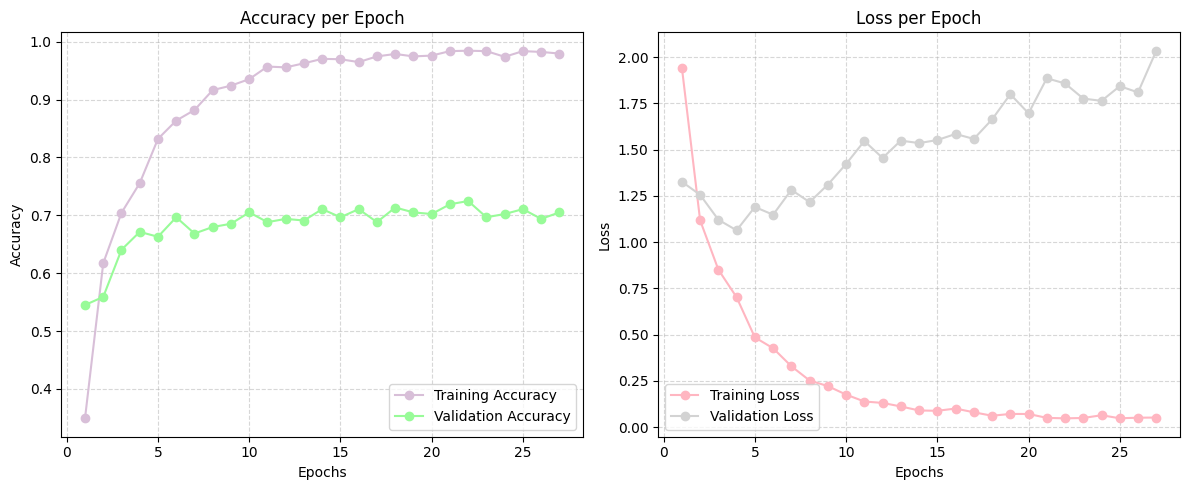

In [ ]:
acc = history_cnn.history['accuracy']
val_acc = history_cnn.history['val_accuracy']
loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize = (12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, color = 'thistle', marker = 'o', label = 'Training Accuracy')
plt.plot(epochs, val_acc, color = 'palegreen', marker = 'o', label = 'Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha = 0.5, linestyle = '--')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, color = 'lightpink', marker = 'o', label = 'Training Loss')
plt.plot(epochs, val_loss, color = 'lightgray', marker = 'o', label = 'Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha = 0.5, linestyle = '--')

plt.tight_layout()
plt.show()

# **6. DenseNet121**

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## 6.1. Model Architecture

> Transfer learning was applied using **DenseNet121** pre-trained on `ImageNet`.

> The original classification head (`include_top=False`) was removed, and a custom fully connected head was added:

    Flatten → Dense(128) → Dropout(0.5) → Dense(8, softmax)

> All base model layers were frozen to retain pre-learned visual features.

> The model was compiled using **Adam optimizer** with a learning rate of `1e-4`, and `categorical_crossentropy` as the loss function.

In [ ]:
input_shape = (224, 224, 3)
num_classes = 8

base_model = DenseNet121(weights = 'imagenet', include_top = False, input_tensor = Input(shape = input_shape))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation = 'softmax')(x)

# Final model
model_densenet = Model(inputs = base_model.input, outputs = output)

# Compile
model_densenet.compile(
    optimizer = Adam(learning_rate = 1e-4),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

model_densenet.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 13,461,192 (51.35 MB)

 Trainable params: 6,423,688 (24.50 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

## 6.2. Training

With training, after all steps were performed using the same approach as the Custom CNN model.

> The best-performing model was saved as `"best_model_densenet.keras"`.

> Accuracy and loss were tracked using `history_densenet`, while confusion matrix and classification metrics were computed from model predictions, all recorded for model comparison.

In [ ]:
early_stop = EarlyStopping(
    monitor = 'val_accuracy',
    patience = 5,
    restore_best_weights = True
    )

checkpoint = ModelCheckpoint(
    "best_model_densenet.keras",
    monitor = 'val_accuracy',
    save_best_only = True,
    verbose = 1
    )

In [ ]:
import time
start = time.time()

history_densenet = model_densenet.fit(
    X_train, y_train,
    validation_data = (X_test, y_test),
    epochs = 100,
    batch_size = 32,
    callbacks = [early_stop, checkpoint],
    verbose = 1
)

end = time.time()
total_seconds = end - start
minutes = total_seconds // 60
seconds = total_seconds % 60

print(f"Training time: {int(minutes)} minutes {int(seconds)} seconds")

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_45']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.5335 - loss: 1.8018
Epoch 1: val_accuracy improved from -inf to 0.86798, saving model to best_model_densenet.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 62s 827ms/step - accuracy: 0.5369 - loss: 1.7868 - val_accuracy: 0.8680 - val_loss: 0.4752
Epoch 2/100
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8509 - loss: 0.5407
Epoch 2: val_accuracy improved from 0.86798 to 0.87079, saving model to best_model_densenet.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 0.8507 - loss: 0.5400 - val_accuracy: 0.8708 - val_loss: 0.4508
Epoch 3/100
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8620 - loss: 0.4521
Epoch 3: val_accuracy did not improve from 0.87079
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.8619 - loss: 0.4526 - val_accuracy: 0.8680 - val_loss: 0.4135
Epoch 4/100
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8727 - loss: 0.3939
Epoch 4: val_accuracy did not improve from 0.87079
45/45 ━━━━━━━━━━━━━━━

## 6.3. Evaluation

In [ ]:
from tensorflow.keras.models import load_model

model = load_model("best_model_densenet.keras")

loss, acc = model.evaluate(X_test, y_test, verbose = 1)
print(f"\nTest Accuracy: {acc:.4f} — Test Loss: {loss:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 551ms/step - accuracy: 0.9043 - loss: 0.3890

Test Accuracy: 0.8848 — Test Loss: 0.4303


## 6.4. Prediction

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [ ]:
best_model = load_model("best_model_densenet.keras")

y_pred_probs = best_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)


if y_test.ndim > 1 and y_test.shape[1] > 1:
    y_true = np.argmax(y_test, axis=1)
else:
    y_true = y_test

class_names = ["1", "2", "3", "4a", "4b", "4c", "5", "6"]

12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 944ms/step


## 6.5. Classification Report

In [ ]:
print("DenseNet121 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

DenseNet121 Classification Report:

              precision    recall  f1-score   support

           1       0.86      0.80      0.83        45
           2       0.58      0.86      0.69        44
           3       1.00      0.93      0.96        44
          4a       1.00      0.89      0.94        44
          4b       1.00      0.95      0.98        44
          4c       0.88      0.84      0.86        45
           5       1.00      0.80      0.89        45
           6       0.96      1.00      0.98        45

    accuracy                           0.88       356
   macro avg       0.91      0.89      0.89       356
weighted avg       0.91      0.88      0.89       356



## 6.6. Confusion Matrix

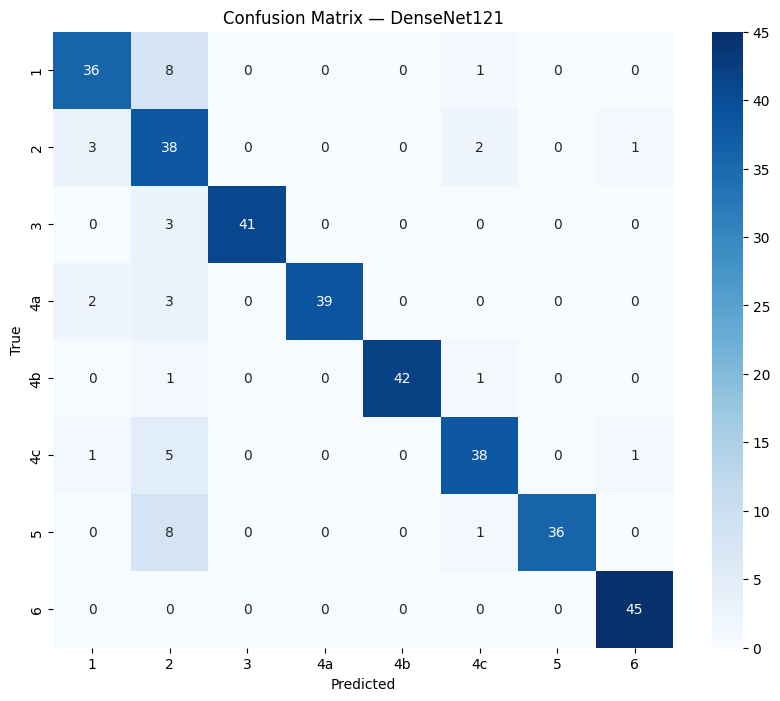

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize = (10, 8))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = class_names, yticklabels = class_names)
plt.title("Confusion Matrix — DenseNet121")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## 6.7. Accuracy & Loss Graphs

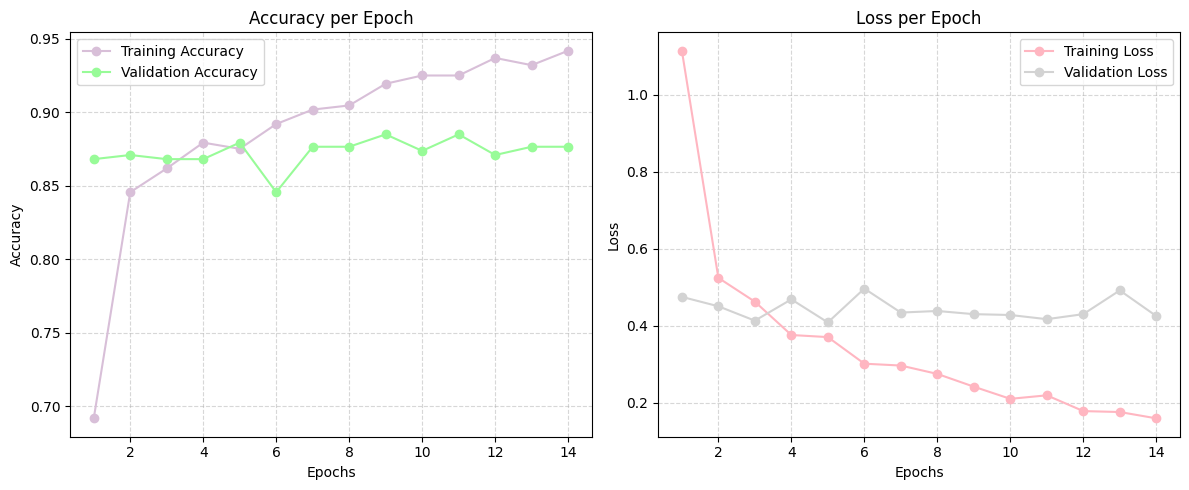

In [ ]:
import matplotlib.pyplot as plt

acc = history_densenet.history['accuracy']
val_acc = history_densenet.history['val_accuracy']
loss = history_densenet.history['loss']
val_loss = history_densenet.history['val_loss']
epochs = range(1, len(acc) + 1)

# Accuracy plot
plt.figure(figsize = (12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, color = 'thistle', marker = 'o', label = 'Training Accuracy')
plt.plot(epochs, val_acc, color = 'palegreen', marker = 'o', label = 'Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha = 0.5, linestyle = '--')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, color = 'lightpink', marker='o', label = 'Training Loss')
plt.plot(epochs, val_loss, color = 'lightgray', marker = 'o', label = 'Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha = 0.5, linestyle = '--')

plt.tight_layout()
plt.show()

# **7. VGG16**

## 7.1. Feature Extraction

Transfer learning was applied using VGG16 with `ImageNet` weights.

> The original classification layers were removed (`include_top=False`), and all base layers were frozen.

> Custom classification head was added:

    Flatten → Dense(128) → Dropout(0.5) → Dense(8, softmax)

> The model was compiled using the **Adam optimizer** and `categorical_crossentropy` loss.

> This configuration enables the reuse of generalized visual features while adapting only the final layers to the BI-RADS classification task.

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

input_shape = (224, 224, 3)
num_classes = 8

base_model = VGG16(weights = 'imagenet', include_top = False, input_tensor = Input(shape = input_shape))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation = 'softmax')(x)

# Final model
model_vgg16 = Model(inputs = base_model.input, outputs = output)

# Compile
model_vgg16.compile(
    optimizer = Adam(learning_rate = 1e-4),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

model_vgg16.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,927,112 (68.39 MB)

 Trainable params: 3,212,424 (12.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

## 7.2. Training

Training configuration, evaluation steps, and metrics visualization followed the same pipeline as in previous models.

> The best-performing model (`"best_model_vgg16.keras"`) was saved.

> The training process was stored in the `history_vgg16` object.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor = 'val_accuracy', patience = 5, restore_best_weights = True)

checkpoint = ModelCheckpoint(
    "best_model_vgg16.keras",
    monitor = 'val_accuracy',
    save_best_only = True,
    verbose = 1
)

In [ ]:
import time
start = time.time()

history_vgg16 = model_vgg16.fit(
    X_train, y_train,
    validation_data = (X_test, y_test),
    epochs = 100,
    batch_size = 32,
    callbacks = [early_stop, checkpoint],
    verbose = 1
)

end = time.time()
total_seconds = end - start
minutes = total_seconds // 60
seconds = total_seconds % 60

print(f"Training time: {int(minutes)} minutes {int(seconds)} seconds")

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2312']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.3568 - loss: 1.8448
Epoch 1: val_accuracy improved from -inf to 0.75000, saving model to best_model_vgg16.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 38s 546ms/step - accuracy: 0.3607 - loss: 1.8364 - val_accuracy: 0.7500 - val_loss: 0.8971
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.7650 - loss: 0.8574
Epoch 2: val_accuracy improved from 0.75000 to 0.82584, saving model to best_model_vgg16.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 229ms/step - accuracy: 0.7652 - loss: 0.8566 - val_accuracy: 0.8258 - val_loss: 0.6757
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.8244 - loss: 0.6254
Epoch 3: val_accuracy improved from 0.82584 to 0.85955, saving model to best_model_vgg16.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 224ms/step - accuracy: 0.8241 - loss: 0.6259 - val_accuracy: 0.8596 - val_loss: 0.5834
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8500 - loss: 0.5478
Epoch 4: val_accuracy did no

## 7.3. Evaluation

In [ ]:
from tensorflow.keras.models import load_model

best_model_vgg16 = load_model("best_model_vgg16.keras")
loss, acc = model_vgg16.evaluate(X_test, y_test, verbose=1)
print(f"\n Test Accuracy: {acc:.4f} — Test Loss: {loss:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - accuracy: 0.8700 - loss: 0.4716

 Test Accuracy: 0.8680 — Test Loss: 0.4814


## 7.4. Prediction

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [ ]:
best_model = load_model("best_model_vgg16.keras")

y_pred_probs = best_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)


if y_test.ndim > 1 and y_test.shape[1] > 1:
    y_true = np.argmax(y_test, axis=1)
else:
    y_true = y_test

class_names = ["1", "2", "3", "4a", "4b", "4c", "5", "6"]

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 200ms/step


## 7.5. Classification Report

In [ ]:
print("VGG16 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

VGG16 Classification Report:

              precision    recall  f1-score   support

           1       0.89      0.76      0.82        45
           2       0.53      0.77      0.63        44
           3       0.98      0.93      0.95        44
          4a       0.93      0.89      0.91        44
          4b       0.95      0.95      0.95        44
          4c       0.88      0.84      0.86        45
           5       0.97      0.80      0.88        45
           6       0.98      1.00      0.99        45

    accuracy                           0.87       356
   macro avg       0.89      0.87      0.87       356
weighted avg       0.89      0.87      0.87       356



## 7.6. Confusion Matrix

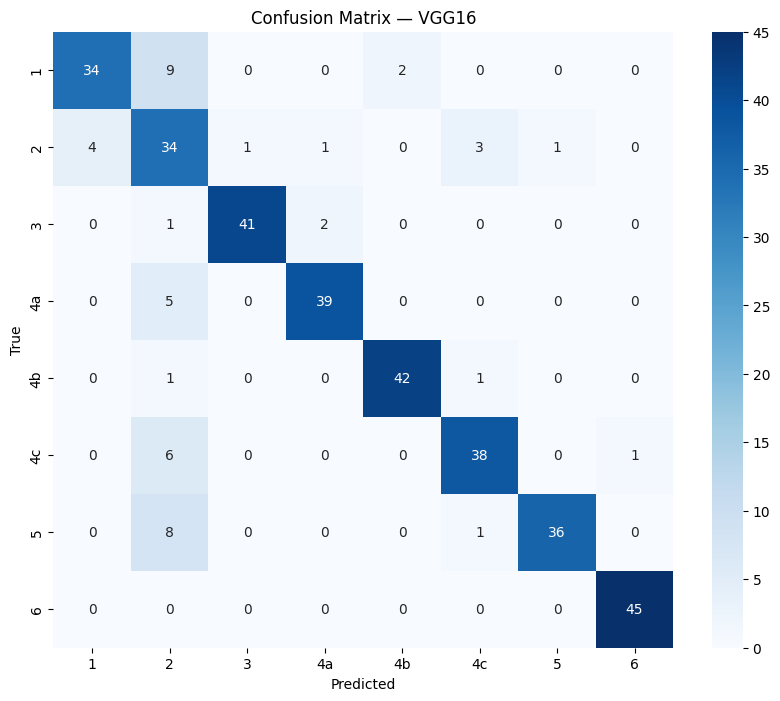

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize = (10, 8))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = class_names, yticklabels = class_names)
plt.title("Confusion Matrix — VGG16")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## 7.7. Accuracy & Loss Graphs

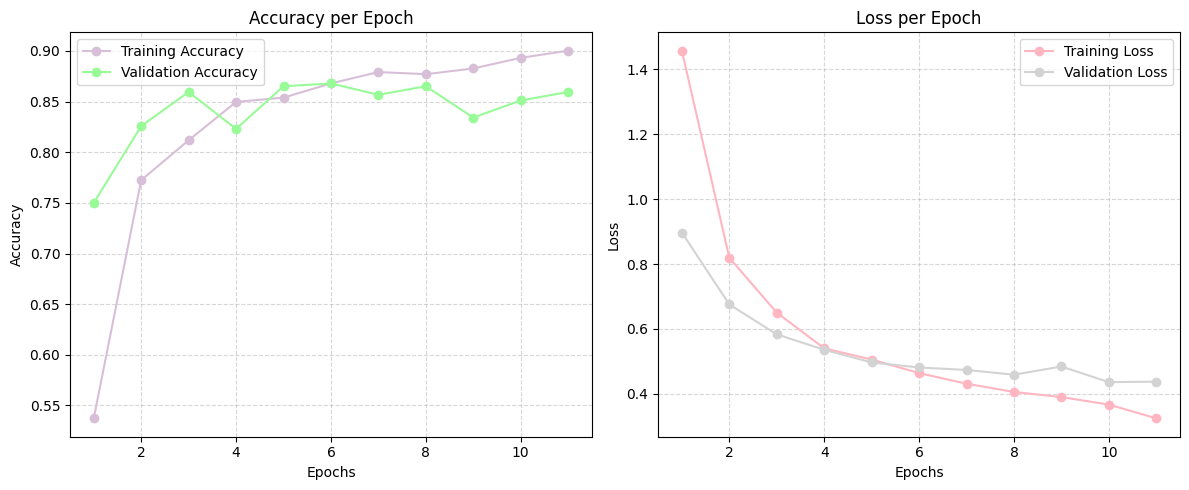

In [ ]:
import matplotlib.pyplot as plt

acc = history_vgg16.history['accuracy']
val_acc = history_vgg16.history['val_accuracy']
loss = history_vgg16.history['loss']
val_loss = history_vgg16.history['val_loss']
epochs = range(1, len(acc) + 1)

# Accuracy plot
plt.figure(figsize = (12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, color = 'thistle', marker = 'o', label = 'Training Accuracy')
plt.plot(epochs, val_acc, color = 'palegreen', marker = 'o', label = 'Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha = 0.5, linestyle = '--')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, color = 'lightpink', marker='o', label = 'Training Loss')
plt.plot(epochs, val_loss, color = 'lightgray', marker = 'o', label = 'Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha = 0.5, linestyle = '--')

plt.tight_layout()
plt.show()

# **8. EfficientNetB0**

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

## 8.1. Feature Extraction

EfficientNetB0 model was implemented using pre-trained `ImageNet` weights with the transfer learning method.

> The original classification layer was removed (`include_top = False`), and base layers were frozen (`trainable = False`).

> `GlobalAveragePooling2D` layer reduced the spatial dimensions, followed by:

    Dense(128) → Dropout(0.5) → Dense(8, softmax)

> The model was compiled using the **Adam optimizer** and `categorical_crossentropy` for 8-class classification.

In [ ]:
input_shape = (224, 224, 3)
num_classes = 8

base_model = EfficientNetB0(weights = 'imagenet', include_top = False, input_tensor = Input(shape = input_shape))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation = 'softmax')(x)

# Final model
model_efficientnet = Model(inputs = base_model.input, outputs = output)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Compile
model_efficientnet.compile(
    optimizer = Adam(learning_rate = 1e-4),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

model_efficientnet.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_3[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,214,571 (16.08 MB)

 Trainable params: 165,000 (644.53 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

## 8.2. Training

> Training, evaluation, and visualization steps followed the standard pipeline established in previous models.

> Model that achieved the best validation result was saved named `"best_model_efficientnet.keras"`.

> During training, accuracy and loss metrics were collected in the `history_efficient` object.

In [ ]:
early_stop = EarlyStopping(
    monitor = 'val_accuracy',
    patience = 5,
    restore_best_weights = True
    )
checkpoint = ModelCheckpoint(
    "best_model_efficientnet.keras",
    monitor = 'val_accuracy',
    save_best_only = True,
    verbose = 1
    )

In [ ]:
import time
start = time.time()

history_efficient = model_efficientnet.fit(
    X_train, y_train,
    validation_data = (X_test, y_test),
    epochs = 100,
    batch_size = 32,
    callbacks = [early_stop, checkpoint],
    verbose = 1
)

end = time.time()
total_seconds = end - start
minutes = total_seconds // 60
seconds = total_seconds % 60

print(f"Training time: {int(minutes)} minutes {int(seconds)} seconds")

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2423']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.1315 - loss: 2.1188
Epoch 1: val_accuracy improved from -inf to 0.12640, saving model to best_model_efficientnet.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 509ms/step - accuracy: 0.1314 - loss: 2.1186 - val_accuracy: 0.1264 - val_loss: 2.0799
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.1172 - loss: 2.0992
Epoch 2: val_accuracy did not improve from 0.12640
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.1173 - loss: 2.0991 - val_accuracy: 0.1236 - val_loss: 2.0798
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.1409 - loss: 2.0856
Epoch 3: val_accuracy did not improve from 0.12640
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.1408 - loss: 2.0856 - val_accuracy: 0.1264 - val_loss: 2.0800
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.1302 - loss: 2.0839
Epoch 4: val_accuracy did not improve from 0.12640
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.1301 - loss

## 8.3. Evaluation

In [ ]:
from tensorflow.keras.models import load_model

best_model_efficientnet = load_model("best_model_efficientnet.keras")
loss, acc = model_efficientnet.evaluate(X_test, y_test, verbose=1)
print(f"\n Test Accuracy: {acc:.4f} — Test Loss: {loss:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.1304 - loss: 2.0815

 Test Accuracy: 0.1264 — Test Loss: 2.0799


## 8.4. Prediction

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [ ]:
best_model = load_model("best_model_efficientnet.keras")

y_pred_probs = best_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)


if y_test.ndim > 1 and y_test.shape[1] > 1:
    y_true = np.argmax(y_test, axis=1)
else:
    y_true = y_test

class_names = ["1", "2", "3", "4a", "4b", "4c", "5", "6"]

12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 511ms/step


## 8.5. Classification Report

In [ ]:
print("EfficientNetB0 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

EfficientNetB0 Classification Report:

              precision    recall  f1-score   support

           1       0.13      1.00      0.22        45
           2       0.00      0.00      0.00        44
           3       0.00      0.00      0.00        44
          4a       0.00      0.00      0.00        44
          4b       0.00      0.00      0.00        44
          4c       0.00      0.00      0.00        45
           5       0.00      0.00      0.00        45
           6       0.00      0.00      0.00        45

    accuracy                           0.13       356
   macro avg       0.02      0.12      0.03       356
weighted avg       0.02      0.13      0.03       356



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 8.6. Confusion Matrix

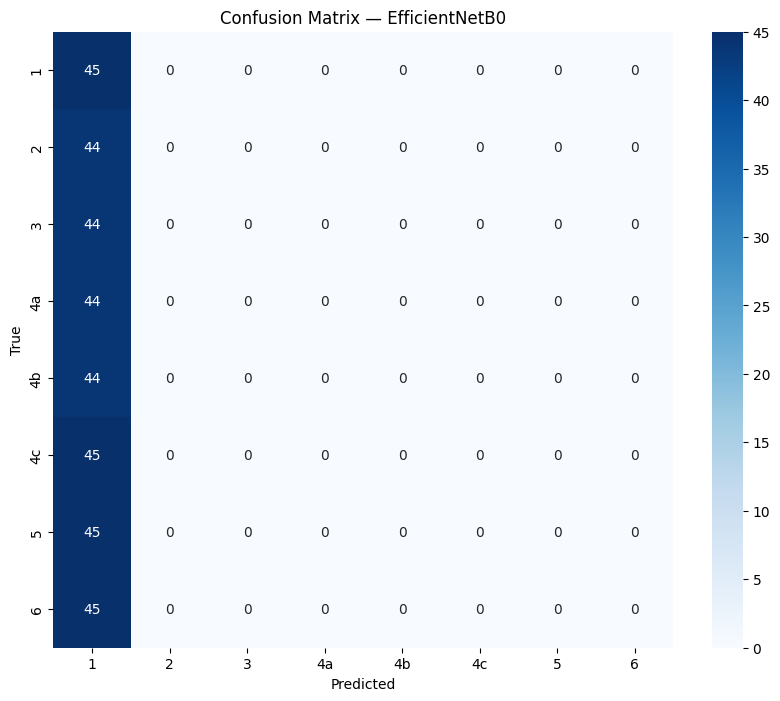

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize = (10, 8))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = class_names, yticklabels = class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix — EfficientNetB0')
plt.show()

## 8.7. Accuracy & Loss Graphs

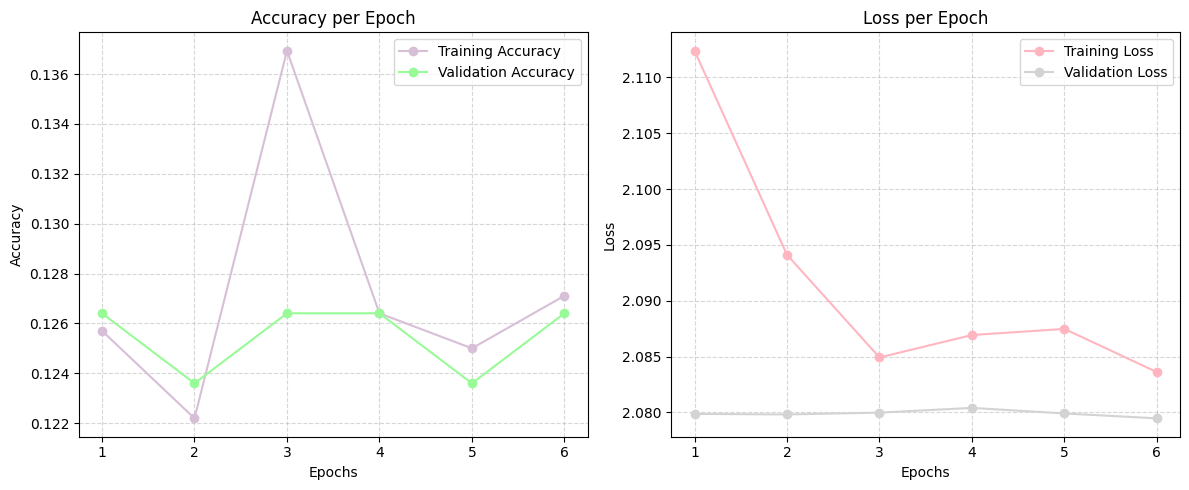

In [ ]:
import matplotlib.pyplot as plt

acc = history_efficient.history['accuracy']
val_acc = history_efficient.history['val_accuracy']
loss = history_efficient.history['loss']
val_loss = history_efficient.history['val_loss']
epochs = range(1, len(acc) + 1)

# Accuracy plot
plt.figure(figsize = (12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, color = 'thistle', marker = 'o', label = 'Training Accuracy')
plt.plot(epochs, val_acc, color = 'palegreen', marker = 'o', label = 'Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha = 0.5, linestyle = '--')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, color = 'lightpink', marker='o', label = 'Training Loss')
plt.plot(epochs, val_loss, color = 'lightgray', marker = 'o', label = 'Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha = 0.5, linestyle = '--')

plt.tight_layout()
plt.show()

## 8.8. Fine-Tuning

Fine-Tuning was applied to enhance performance.

> First, all layers were frozen:

    for layer in base_model.layers:
        layer.trainable = False

> Then, only the last 20 layers were unfrozen to make them trainable.

> This enabled the model to learn deeper features and better adapt to the specific dataset.

> The model was recompiled with a **reduced learning rate** (`1e-5`).

> Additional training was conducted for 20 epochs, and training history was stored in `history_efficient_finetuned`, while best performance was saved as `"best_model_efficientnet_finetuned.keras"`.

In [ ]:
# Freeze all layers
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze last 20 layers
for layer in base_model.layers[-20:]:
    layer.trainable = True

In [ ]:
from tensorflow.keras.optimizers import Adam

model_efficientnet.compile(
    optimizer = Adam(learning_rate = 1e-5),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

### 8.8.1. Fine-Tuning Training

In [ ]:
early_stop = EarlyStopping(
    monitor = 'val_accuracy',
    patience = 5,
    restore_best_weights = True
    )
checkpoint = ModelCheckpoint(
    "best_model_efficientnet_finetuned.keras",
    monitor = 'val_accuracy',
    save_best_only = True,
    verbose = 1
    )

In [ ]:
# Training
fine_tune_start = time.time()

history_efficient_finetuned = model_efficientnet.fit(
    X_train, y_train,
    validation_data = (X_test, y_test),
    epochs = 20,
    batch_size = 32,
    callbacks = [early_stop, checkpoint],
    verbose = 1
)

fine_tune_end = time.time()
ft_minutes = (fine_tune_end - fine_tune_start) // 60
ft_seconds = (fine_tune_end - fine_tune_start) % 60

print(f"Fine-Tuning Time: {int(ft_minutes)} minutes {int(ft_seconds)} seconds")

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2423']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.1259 - loss: 2.1245
Epoch 1: val_accuracy improved from -inf to 0.12360, saving model to best_model_efficientnet_finetuned.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 46s 520ms/step - accuracy: 0.1258 - loss: 2.1246 - val_accuracy: 0.1236 - val_loss: 2.0817
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.1192 - loss: 2.1096
Epoch 2: val_accuracy did not improve from 0.12360
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.1194 - loss: 2.1094 - val_accuracy: 0.1236 - val_loss: 2.0843
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.1215 - loss: 2.1049
Epoch 3: val_accuracy did not improve from 0.12360
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.1216 - loss: 2.1048 - val_accuracy: 0.1236 - val_loss: 2.0853
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.1232 - loss: 2.0922
Epoch 4: val_accuracy did not improve from 0.12360
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.1232

### 8.8.2. Accuracy and Loss Comparison: Initial Training vs. Fine-Tuning

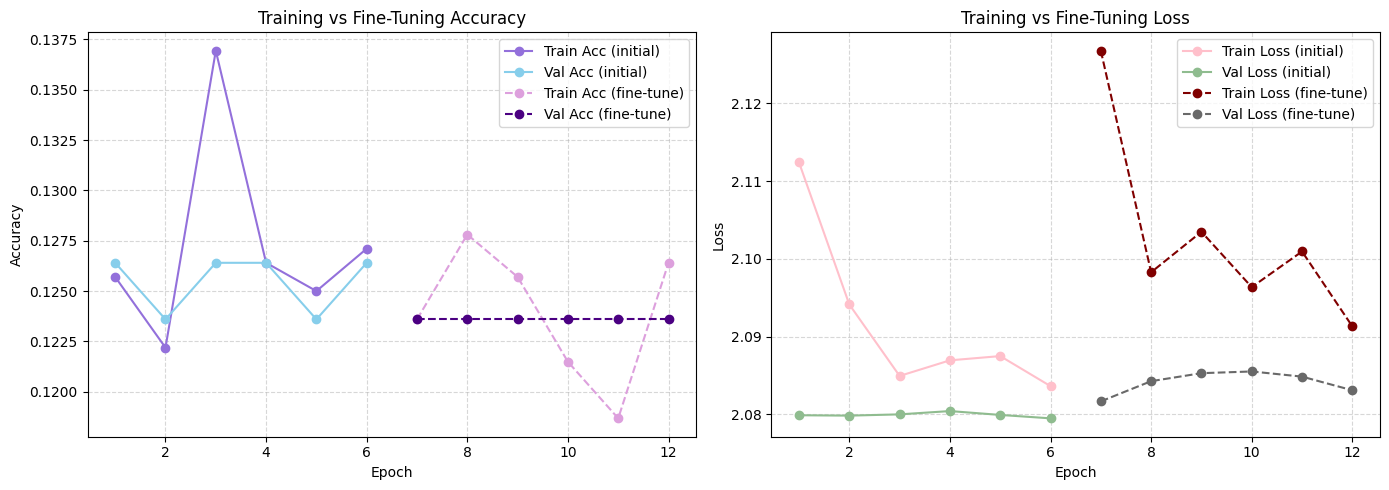

In [ ]:
import matplotlib.pyplot as plt

# Extract history
acc_initial = history_efficient.history['accuracy']
val_acc_initial = history_efficient.history['val_accuracy']
loss_initial = history_efficient.history['loss']
val_loss_initial = history_efficient.history['val_loss']

acc_ft = history_efficient_finetuned.history['accuracy']
val_acc_ft = history_efficient_finetuned.history['val_accuracy']
loss_ft = history_efficient_finetuned.history['loss']
val_loss_ft = history_efficient_finetuned.history['val_loss']

# Epochs
epochs_initial = range(1, len(acc_initial) + 1)
epochs_ft = range(len(acc_initial) + 1, len(acc_initial) + len(acc_ft) + 1)

plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs_initial, acc_initial, 'o-', label = 'Train Acc (initial)', color = 'mediumpurple')
plt.plot(epochs_initial, val_acc_initial, 'o-', label='Val Acc (initial)', color = 'skyblue')
plt.plot(epochs_ft, acc_ft, 'o--', label = 'Train Acc (fine-tune)', color = 'plum')
plt.plot(epochs_ft, val_acc_ft, 'o--', label = 'Val Acc (fine-tune)', color = 'indigo')
plt.title('Training vs Fine-Tuning Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha = 0.5, linestyle = '--')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_initial, loss_initial, 'o-', label = 'Train Loss (initial)', color = 'pink')
plt.plot(epochs_initial, val_loss_initial, 'o-', label='Val Loss (initial)', color = 'darkseagreen')
plt.plot(epochs_ft, loss_ft, 'o--', label = 'Train Loss (fine-tune)', color = 'maroon')
plt.plot(epochs_ft, val_loss_ft, 'o--', label = 'Val Loss (fine-tune)', color = 'dimgray')
plt.title('Training vs Fine-Tuning Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha = 0.5, linestyle = '--')

plt.tight_layout()
plt.show()

According to the graphs, the fine-tuning process was initiated, but the model’s overall performance remains low.

> Validation accuracy has plateaued around 12–13%, indicating no improvement on the validation set.

> Although training accuracy increased during fine-tuning, the unchanged validation accuracy raises concerns about overfitting.

> Moreover, the upward trend in validation loss suggests that the model struggles to generalize well to unseen data.

# **9. ResNet50**

ResNet50 allows learning more robust features by preventing information loss due to depth thanks to residual connections.

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## 9.1. Feature Extraction

Transfer learning was applied using **ResNet50** with `ImageNet` weights.

> The original top layers were removed, and all base layers were frozen.

> Feature maps were passed through `GlobalAveragePooling2D`, followed by:

    Dense(128) → Dropout(0.5) → Dense(8, softmax)

> The model was compiled using the **Adam optimizer** and `categorical_crossentropy` loss function.

In [ ]:
input_shape = (224, 224, 3)
num_classes = 8

base_model = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape = input_shape))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation = 'softmax')(x)

model_resnet50 = Model(inputs = base_model.input, outputs = output)

# Compile
model_resnet50.compile(
    optimizer = Adam(learning_rate = 1e-4),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

model_resnet50.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,851,016 (90.98 MB)

 Trainable params: 263,304 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

## 9.2. Training

> Training followed the same procedure as previous models.

> The best-performing model (`"best_model_resnet50.keras"`) was saved using `ModelCheckpoint`.

> Training accuracy and loss metrics were stored in the `history_resnet50` object.

> Classification performance, confusion matrix, and metric graphs were generated to compare against other architectures.

In [ ]:
early_stop = EarlyStopping(
    monitor = 'val_accuracy',
    patience = 5,
    restore_best_weights = True
    )
checkpoint = ModelCheckpoint(
    "best_model_resnet50.keras",
    monitor = 'val_accuracy',
    save_best_only = True,
    verbose = 1
    )

In [ ]:
import time
start = time.time()

history_resnet50 = model_resnet50.fit(
    X_train, y_train,
    validation_data = (X_test, y_test),
    epochs = 100,
    batch_size = 32,
    callbacks = [early_stop, checkpoint],
    verbose = 1
)

end = time.time()
total_seconds = end - start
minutes = total_seconds // 60
seconds = total_seconds % 60

print(f"Training time: {int(minutes)} minutes {int(seconds)} seconds")

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_3679']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.1319 - loss: 2.5274
Epoch 1: val_accuracy improved from -inf to 0.12640, saving model to best_model_resnet50.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 29s 386ms/step - accuracy: 0.1318 - loss: 2.5245 - val_accuracy: 0.1264 - val_loss: 2.0685
Epoch 2/100
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.1392 - loss: 2.2265
Epoch 2: val_accuracy improved from 0.12640 to 0.17697, saving model to best_model_resnet50.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 0.1389 - loss: 2.2250 - val_accuracy: 0.1770 - val_loss: 2.0609
Epoch 3/100
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.1287 - loss: 2.1242
Epoch 3: val_accuracy improved from 0.17697 to 0.22472, saving model to best_model_resnet50.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 0.1291 - loss: 2.1239 - val_accuracy: 0.2247 - val_loss: 2.0474
Epoch 4/100
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.1543 - loss: 2.0758
Epoch 4: val_accuracy di

## 9.3. Evaluation

In [ ]:
from tensorflow.keras.models import load_model

best_model_resnet50 = load_model("best_model_resnet50.keras")
loss, acc = model_resnet50.evaluate(X_test, y_test, verbose = 1)
print(f"\n Test Accuracy: {acc:.4f} — Test Loss: {loss:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.5435 - loss: 1.9272

 Test Accuracy: 0.5449 — Test Loss: 1.9284


## 9.4. Prediction

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [ ]:
best_model = load_model("best_model_resnet50.keras")

y_pred_probs = best_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis = 1)


if y_test.ndim > 1 and y_test.shape[1] > 1:
    y_true = np.argmax(y_test, axis = 1)
else:
    y_true = y_test

class_names = ["1", "2", "3", "4a", "4b", "4c", "5", "6"]

12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 378ms/step


## 9.5. Classification Report

In [ ]:
print("ResNet50 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

ResNet50 Classification Report:

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        45
           2       0.00      0.00      0.00        44
           3       0.65      0.91      0.75        44
          4a       0.47      0.93      0.62        44
          4b       0.53      0.89      0.67        44
          4c       0.78      0.78      0.78        45
           5       0.00      0.00      0.00        45
           6       0.45      0.87      0.60        45

    accuracy                           0.54       356
   macro avg       0.36      0.55      0.43       356
weighted avg       0.36      0.54      0.43       356



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 9.6. Confusion Matrix

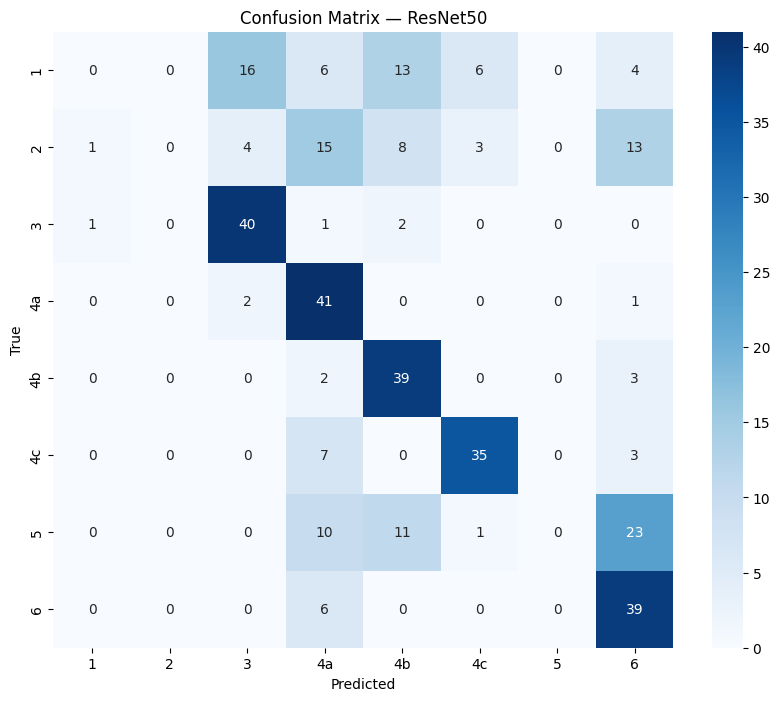

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize = (10, 8))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = class_names, yticklabels = class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix — ResNet50')
plt.show()

## 9.7. Accuracy & Loss Graphs

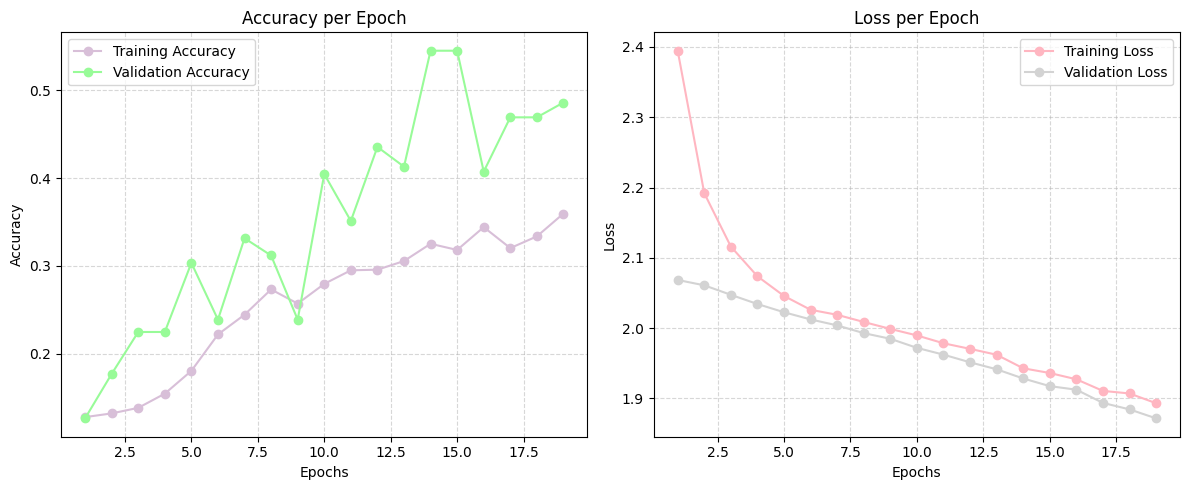

In [ ]:
import matplotlib.pyplot as plt

acc = history_resnet50.history['accuracy']
val_acc = history_resnet50.history['val_accuracy']
loss = history_resnet50.history['loss']
val_loss = history_resnet50.history['val_loss']
epochs = range(1, len(acc) + 1)

# Accuracy
plt.figure(figsize = (12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, color = 'thistle', marker = 'o', label = 'Training Accuracy')
plt.plot(epochs, val_acc, color = 'palegreen', marker = 'o', label = 'Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha = 0.5, linestyle = '--')

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, color = 'lightpink', marker='o', label = 'Training Loss')
plt.plot(epochs, val_loss, color = 'lightgray', marker = 'o', label = 'Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha = 0.5, linestyle = '--')

plt.tight_layout()
plt.show()

# **10. Model Comparison**

In [ ]:
import pandas as pd

model_paths = {
    'CNN': '/content/best_model_cnn.keras',
    'DenseNet121': '/content/best_model_densenet.keras',
    'VGG16': '/content/best_model_vgg16.keras',
    'EfficientNet': '/content/best_model_efficientnet.keras',
    'EfficientNet_FineTuned': '/content/best_model_efficientnet_finetuned.keras',
    'ResNet50': '/content/best_model_resnet50.keras'
}

model_histories = {
    'CNN': history_cnn,
    'DenseNet121': history_densenet,
    'VGG16': history_vgg16,
    'EfficientNet': history_efficient,
    'EfficientNet_FineTuned': history_efficient_finetuned,
    'ResNet50': history_resnet50
}

training_times = {
    'CNN': '1 minutes 14 seconds',
    'DenseNet121': '2 minutes 1 seconds',
    'VGG16': '2 minutes 20 seconds',
    'EfficientNet': '0 minutes 55 seconds',
    'EfficientNet_FineTuned': '0 minutes 59 seconds',
    'ResNet50': '2 minutes 2 seconds',
}

In [ ]:
model_comparisons = []

for model_name, history in model_histories.items():
    hist = history.history

    model_comparisons.append({
        'Model': model_name,
        'Accuracy': round(hist.get('accuracy', [None])[-1], 3),
        'Loss': round(hist.get('loss', [None])[-1], 3),
        'Validation Accuracy': round(hist.get('val_accuracy', [None])[-1], 3),
        'Validation Loss': round(hist.get('val_loss', [None])[-1], 3),
        'Training Time': training_times.get(model_name, 'N/A')
    })

df_comparison = pd.DataFrame(model_comparisons)
display(df_comparison)

,Model,Accuracy,Loss,Validation Accuracy,Validation Loss,Training Time
0,CNN,0.980,0.052,0.705,2.035,1 minutes 14 seconds
1,DenseNet121,0.942,0.160,0.876,0.425,2 minutes 1 seconds
2,VGG16,0.900,0.325,0.860,0.438,2 minutes 20 seconds
3,EfficientNet,0.127,2.084,0.126,2.079,0 minutes 55 seconds
4,EfficientNet_FineTuned,0.126,2.091,0.124,2.083,0 minutes 59 seconds
5,ResNet50,0.360,1.893,0.486,1.872,2 minutes 2 seconds


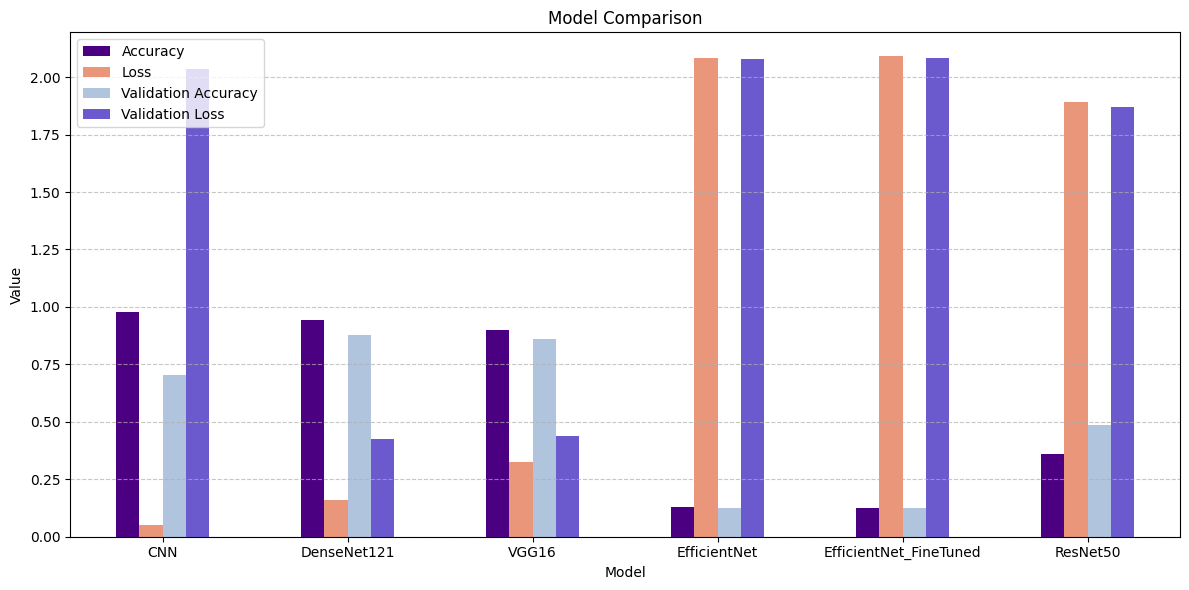

In [ ]:
colors = ['indigo', 'darksalmon', 'lightsteelblue', 'slateblue']

df_comparison.set_index('Model')[['Accuracy', 'Loss', 'Validation Accuracy', 'Validation Loss']].plot(
    kind='bar',
    figsize=(12, 6),
    color=colors
)

plt.title("Model Comparison")
plt.ylabel("Value")
plt.xlabel("Model")
plt.xticks(rotation = 0)
plt.grid(axis = 'y', alpha = 0.7, linestyle = '--')
plt.tight_layout()
plt.show()

After comparing all models based on `training accuracy`and `validation accuracy`, `loss values`, and `training times`, the following results were observed:

> It is clear that **DenseNet121** is the best performing model, balancing high accuracy and low loss in both training and validation phases.

> Despite slightly lower training accuracy, **VGG16** demonstrated superior generalization ability with minimal overfitting.

> **EfficientNet**, **ResNet50** and **Fine-Tuned EfficientNetB0** produced lower validation accuracy and higher loss, indicating underfitting or instability during training.

Considering all performance metrics and training stability, **DenseNet121** was selected as the final model due to its reliable and well-balanced results across all evaluation criteria.

# **11. Prediction & Visualization Preparation**

In [ ]:
pip install roifile

## 11.1. Prediction on Random Test Samples

Randomly selected 9 test images were used to visualize the model's predictions.

> For each image, the true class label was compared with the label predicted by the model (`model_densenet.predict()`).

> If both labels matched, the title was shown in **green**; otherwise, it appeared in **dark red** to indicate a misclassification.

In [ ]:
from tensorflow.keras.preprocessing import image
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.patches as patches
from PIL import Image
import os

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_45']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


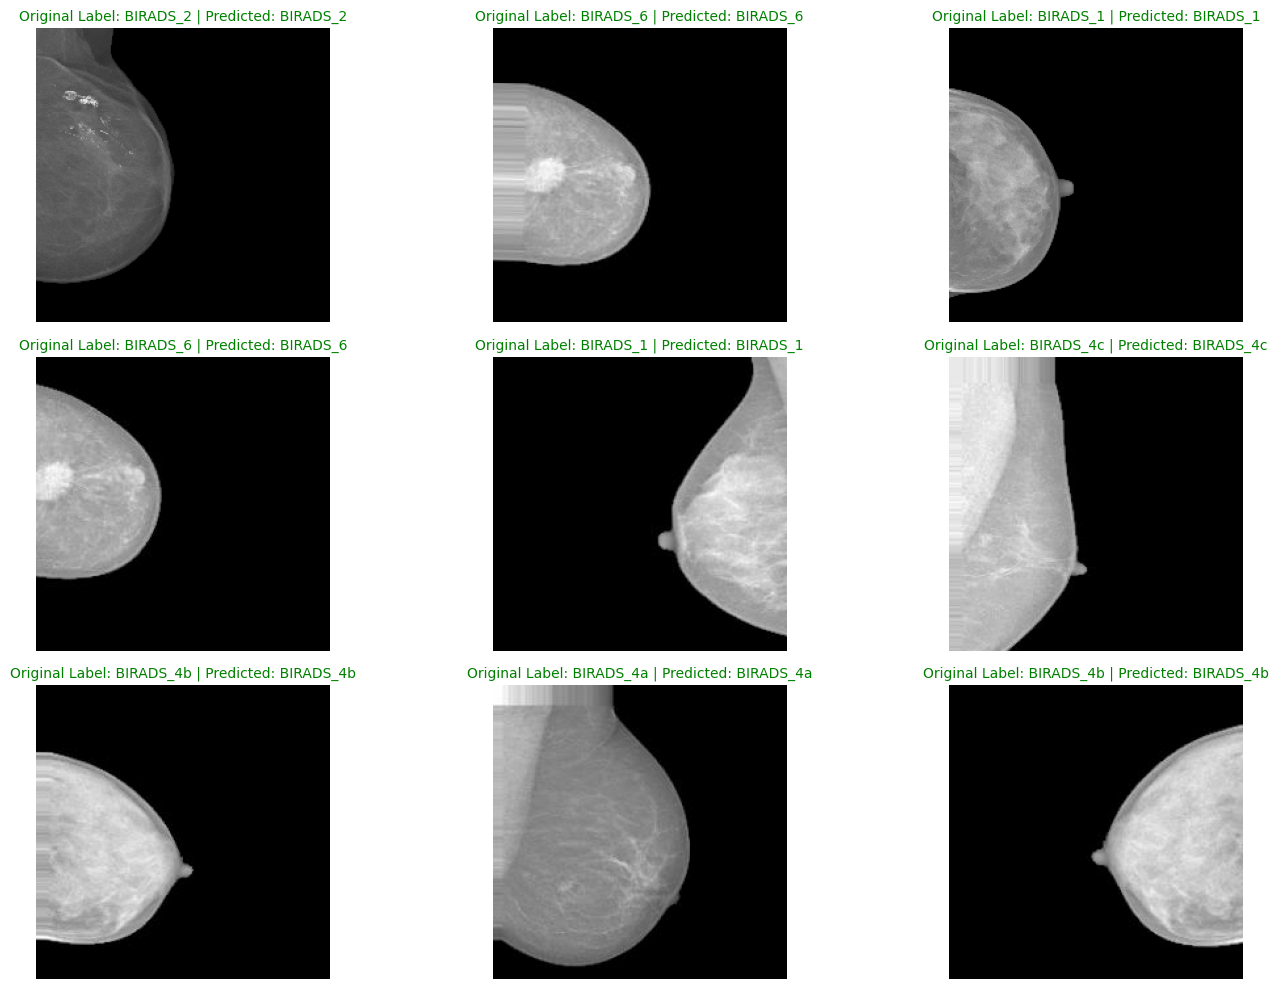

In [ ]:
class_names = ["BIRADS_1", "BIRADS_2", "BIRADS_3", "BIRADS_4a",
               "BIRADS_4b", "BIRADS_4c", "BIRADS_5", "BIRADS_6"]

indices = random.sample(range(len(X_test)), 9)

plt.figure(figsize=(15, 10))

for i, idx in enumerate(indices):
    img_array = X_test[idx]
    true_label = class_names[np.argmax(y_test[idx])] if y_test.ndim == 2 else class_names[y_test[idx]]

    # Prediction
    prediction = model_densenet.predict(np.expand_dims(img_array, axis = 0))
    predicted_label_index = np.argmax(prediction)
    predicted_label = class_names[predicted_label_index]

    # Visualization
    plt.subplot(3, 3, i + 1)
    plt.imshow(img_array)
    plt.axis("off")
    plt.title(f"Original Label: {true_label} | Predicted: {predicted_label}",
          fontsize = 10,
          color = 'green' if true_label == predicted_label else 'darkred')
plt.tight_layout()
plt.show()

## 11.2. Define Risk-Based BI-RADS Color Mapping

To increase clinical interpretability, BI-RADS labels were mapped to colors based on associated risk levels.

> BI-RADS classes were normalized (from 0 to 1) based on their order of risk:
 `1 → lowest risk, 6 → highest risk`.

> The `RdYlGn_r` colormap was used to assign low-risk classes brighter green shades and high-risk classes darker red tones.

> A helper function `get_color_from_birads()` returns the hex(hexadecimal) color code for a BI-RADS label.

> The function `get_roi_color_by_truth()` returns:

* Gray if the label is unknown,

* Black for incorrect predictions,

* Risk-colored hex code for correct predictions.

In [ ]:
# BI-RADS label order and normalized colormap mapping
birads_order = ['1', '2', '3', '4a', '4b', '4c', '5', '6']
birads_normalized = {label: i / (len(birads_order)-1) for i, label in enumerate(birads_order)}
cmap = cm.get_cmap('RdYlGn_r')

def get_color_from_birads(label):
    if label not in birads_normalized:
        return "gray"
    return mcolors.to_hex(cmap(birads_normalized[label]))

def get_roi_color_by_truth(true_label=None, pred_label=None):
    if true_label is None:
        return "mediumpurple"
    if pred_label != true_label:
        return "black"
    return get_color_from_birads(true_label)

color_palette = {label: get_color_from_birads(label) for label in birads_order}
color_palette

<ipython-input-82-ff9932dee3e5>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdYlGn_r')


{'1': '#006837',
 '2': '#39a758',
 '3': '#9dd569',
 '4a': '#e3f399',
 '4b': '#fee999',
 '4c': '#fca55d',
 '5': '#e34933',
 '6': '#a50026'}

## 11.3. Calculate ROI Area and Draw Polygon

> ROI annotations were visualized by overlaying polygons on mammogram images.

> Polygon area was computed using the shoelace formula.

> The fill color reflected classification correctness and risk level.

> A color palette was added to show BI-RADS color mapping and special determined colors for misclassification and unknown labels.

In [ ]:
# Calculate polygon area
def calculate_polygon_area(points):
    x = [p["x"] for p in points]
    y = [p["y"] for p in points]
    return 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))

# ROI + Legend  Visualization
def draw_roi_with_palette(img_path, image_id, annotations, true_label = None, pred_label=None, save_dir = None):
    from matplotlib.patches import Rectangle

    img = Image.open(img_path).convert("RGB")
    img_np = np.array(img)
    rois = annotations.get(image_id, [])
    total_area = 0

    fig, (ax_img, ax_legend) = plt.subplots(1, 2, figsize = (12, 6), gridspec_kw = {'width_ratios': [3, 1]})
    ax_img.imshow(img_np)

    for roi in rois:
        points = roi["points"]
        if len(points) < 3:
            continue
        poly_coords = [(p["x"], p["y"]) for p in points]
        area = calculate_polygon_area(points)
        total_area += area

        color = get_roi_color_by_truth(true_label, pred_label)
        polygon = patches.Polygon(poly_coords, closed = True, edgecolor = color, facecolor = color, alpha = 0.3, linewidth = 2)
        ax_img.add_patch(polygon)

    title = f"Orijinal: {true_label or 'Unknown'}  Predicted: {pred_label or 'Unknown'}\nROI Area: {int(total_area)} pixels²"
    ax_img.set_title(title, fontsize = 12)
    ax_img.axis("off")

    box_height = 0.6
    spacing = 0.15
    extra_items = 2
    full_height = (len(birads_order) + extra_items) * (box_height + spacing)
    ax_legend.set_xlim(0, 1)
    ax_legend.set_ylim(0, full_height)
    ax_legend.axis("off")

    for i, label in enumerate(birads_order):
        y = i * (box_height + spacing)
        color = get_color_from_birads(label)
        ax_legend.add_patch(Rectangle((0.1, y), 0.4, box_height, color = color))
        ax_legend.text(0.55, y + box_height / 2, f"BI-RADS {label}", va = 'center', ha = 'left', fontsize = 10)

    y = len(birads_order) * (box_height + spacing)
    ax_legend.add_patch(Rectangle((0.1, y), 0.4, box_height, color = "black"))
    ax_legend.text(0.55, y + box_height / 2, "Misestimation", va = 'center', ha = 'left', fontsize = 10)

    y = (len(birads_order) + 1) * (box_height + spacing)
    ax_legend.add_patch(Rectangle((0.1, y), 0.4, box_height, color = "mediumpurple"))
    ax_legend.text(0.55, y + box_height / 2, "Unknown", va = 'center', ha = 'left', fontsize = 10)

    plt.tight_layout()
    if save_dir:
        os.makedirs(save_dir, exist_ok = True)
        out_path = os.path.join(save_dir, image_id.replace(".jpg", "_with_palette.png"))
        plt.savefig(out_path)
        plt.close()
    else:
        plt.show()

## 11.4. Extract True Label for Given Image

The actual BI-RADS label corresponding to a given image was extracted using its `filename`.

> The image ID was processed by removing the `.jpg` extension.

> A row containing the matching filename was searched within the `df_clean` DataFrame.

> If a match was found, the associated `birads_label` was returned as a string. Otherwise, `"Unknown"` was returned.

In [ ]:
def extract_label(image_id):
    image_id = image_id.replace(".jpg", "")
    match = df_clean[df_clean['filename'].str.contains(image_id, case = False, na = False)]
    if not match.empty:
        label_value = str(match.iloc[0]['birads_label'])
        return label_value
    return "Unknown"

# **12. Final ROI Visualization with Best Model Prediction**

A random test image with a valid polygon ROI was drawn for final visualization.

> The image was resized and normalized before being passed to the final model **DenseNet121**.

> The predicted BI-RADS label was obtained using `np.argmax()`, and the true label was extracted from the metadata using the `extract_label()` function.

> Finally, `draw_roi_with_palette()` function was used to overlay the ROI annotations with risk-based coloring, and to display both the predicted and true labels.

This visualization was performed to demonstrate how the final model behaves on a real test sample, combining classification and annotated region analysis.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


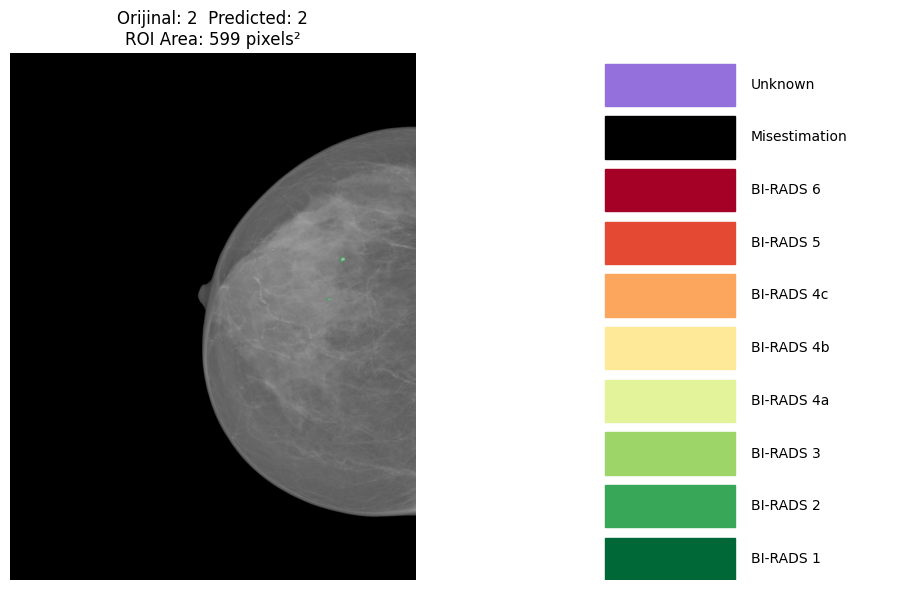

In [ ]:
# Select random test image
valid_ids_with_polygon = [k for k, v in annotations.items() if any(len(roi["points"]) >= 3 for roi in v)]
sample_id = random.choice(valid_ids_with_polygon)
img_path = f"/content/JPGs/{sample_id}"

# Load image
img = Image.open(img_path).resize((224, 224)).convert("RGB")
img_array = np.array(img) / 255.0
input_img = np.expand_dims(img_array, axis=0)

# Predict with DenseNet121
prediction = model_densenet.predict(input_img)
pred_label_index = np.argmax(prediction)
pred_label = birads_order[pred_label_index]

true_label = extract_label(sample_id)

# Draw ROI and palette
draw_roi_with_palette(
    img_path = img_path,
    image_id = sample_id,
    annotations = annotations,
    true_label = true_label,
    pred_label = pred_label,
    save_dir = None
)